# Homework 5
### by Bern Lior 206263071, Lissitsa Denis 314880477 & Sitruk Liron 315151936

## Question 1

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd
import statsmodels.api as sm

In [63]:
#Global parameters
colors=['#006BA6','#7EB77F','#FFBC42','#D81159','#8F2D56']
xticks=np.arange(-16,17,2)
np.random.seed(69)

In [64]:
#Simulating Neurons
distA=stats.norm(loc=35, scale=7) #creating normal distribution
distB=stats.poisson(mu=20) #creating poisson distribution
distC=stats.uniform(loc=20, scale=20) #creating uniform distribution
distributions={'A':distA,'B':distB,'C':distC} 
samples={}
N=35 #number of trials
stimuli=np.arange(-16,17) #stimuli values
for key,value in distributions.items(): #loop for sampling each distributions
    samples[key]=np.empty((N,0))
    for i in stimuli: #loop for itterating over stimuli values
        trials=value.rvs(size=N).reshape(N,1) #creating 'trial measurement' by sampling N random samples 
        samples[key]=np.concatenate((samples[key], trials), axis=1) #creating a Nx33 matrix for each neuron

### Section a

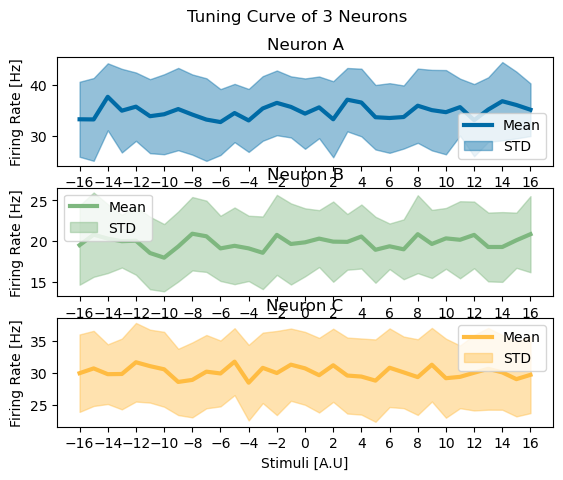

In [65]:
#Plotting 
fig,axs=plt.subplots(3,1)
for i,(key,value) in enumerate(samples.items()):
    means=np.mean(value, axis=0)
    stds=np.std(value, axis=0)
    axs[i].plot(stimuli,means,c=colors[i],label='Mean',linewidth=3)
    axs[i].fill_between(stimuli, means - stds, means + stds, alpha=0.420, label='STD',color=colors[i])
    axs[i].set_xticks(xticks)
    axs[i].set_title('Neuron '+key)
    axs[i].set_xlabel('Stimuli [A.U]')
    axs[i].set_ylabel('Firing Rate [Hz]')
    axs[i].legend()
plt.suptitle('Tuning Curve of 3 Neurons')
plt.show()

### Section b

In [66]:
#calculating mean firing rate of each neuron across trials and stimuli
meanFR={'Neuron '+key:np.mean(value) for key,value in samples.items()} 
print('Mean firing rate of each neuron:')
print(meanFR)

Mean firing rate of each neuron:
{'Neuron A': 34.81293054922771, 'Neuron B': 19.78874458874459, 'Neuron C': 30.055312882447506}


### Section c

In [67]:
#Creating Function for calculating Likelihood values
def poisson(x,lamda): #x is given firing rate; lamda is mean firing rate for given stimulus value
    return (np.exp(-lamda)*np.power(lamda,x))/(np.math.factorial(x))
#calculating likelihood of getting a given firing rate when neuron is stimulated by each stimuli value
trialFR=[32,24,27] #given firing rated
likelihoods={}
for i,(key,value) in enumerate(samples.items()):
    likelihood=[] #vector for storing likelihood values for each stimuli value
    x=trialFR[i]
    for j in range(value.shape[1]):
        lamda=np.mean(value[:,j]) #calculating mean FR for current stimuli value
        likelihood.append(poisson(x, lamda)) 
    likelihoods[key]=np.array(likelihood)

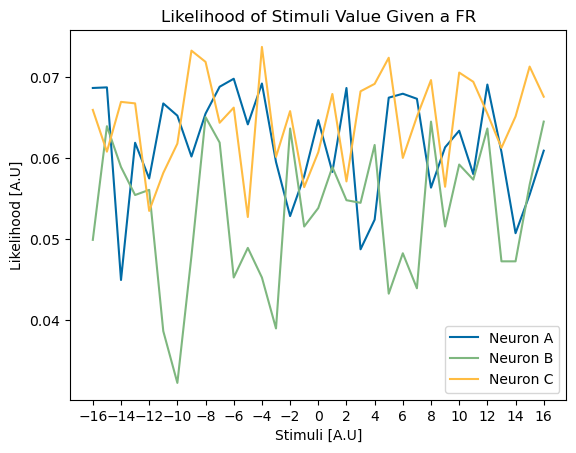

In [68]:
#plotting
plt.figure()    
# fig,ax=plt.subplots()
for i,(key,value) in enumerate(likelihoods.items()):
    plt.plot(stimuli,value,label='Neuron '+key,c=colors[i])
plt.legend()
plt.title('Likelihood of Stimuli Value Given a FR')
plt.xticks(xticks)
plt.xlabel('Stimuli [A.U]')
plt.ylabel('Likelihood [A.U]')
plt.show()  

### Section d

In [69]:
MLEs={key:(max(value),stimuli[np.where(value == max(value))]) for key,value in likelihoods.items()} #dict for holding MLEs and the coresponding stimulus values
print('The MLEs for the 3 neurons are as follows:')
for key,value in MLEs.items():
    print('Neuron '+key+':', 'The MLE is: ', round(value[0],3), 'and the most likely stimulus value is:' ,value[1])


The MLEs for the 3 neurons are as follows:
Neuron A: The MLE is:  0.07 and the most likely stimulus value is: [-6]
Neuron B: The MLE is:  0.065 and the most likely stimulus value is: [-8]
Neuron C: The MLE is:  0.074 and the most likely stimulus value is: [-4]


### Section e

In [70]:
PopLogLikelihood=[] #list for holding the population's log-likelihood for each stimlus value
for i in range(33): #loop for each stimulus value
    product=1 #starting product
    for j,value in enumerate(samples.values()): #loop for each neuron
        x=trialFR[j] #the x is the given FR for each neuron
        lamda=np.mean(value[:,i]) #lambda is the mean FR for each stimulus
        product*=poisson(x, lamda) #the population likelihood is the product of probabilities from the poisson function
    PopLogLikelihood.append(np.log(product)) #turning likelihood into log likelihood
print("The population's log likelihoods for each stimuli value are:\n",[round(x,3) for x in PopLogLikelihood])
print("According to the population's maximum log likelihood, the most likely stimulus value is:",stimuli[np.argmax(PopLogLikelihood)] )


The population's log likelihoods for each stimuli value are:
 [-8.396, -8.229, -8.64, -8.383, -8.667, -8.806, -8.95, -8.463, -8.092, -8.203, -8.474, -8.708, -8.375, -8.879, -8.417, -8.693, -8.463, -8.365, -8.447, -8.617, -8.408, -8.464, -8.535, -8.557, -8.283, -8.632, -8.238, -8.375, -8.154, -8.647, -8.766, -8.404, -8.235]
According to the population's maximum log likelihood, the most likely stimulus value is: -8


## Question 2

### Section a

In [71]:
#simulating the electrodes by drawing a firing rate from the appropriate distribution for each electrode
odd=stats.norm(loc=15, scale=5) #distribution for odd electrodes
even=stats.uniform(loc=5, scale=20) #distribution for even electrodes
recordings=np.empty((0,64)) 
for i in range(100): #100 subjects
    odds=odd.rvs(size=32)
    evens=even.rvs(size=32)
    electrodes=np.array([x for t in zip(odds, evens) for x in t]).reshape(1,64) #simulating the recording for one subject by interweaving the simulated odd and even electrodes
    recordings=np.concatenate((recordings,electrodes))

### Section b

In [72]:
#performing PCA for 2 components
pca=PCA(n_components=2)
pca.fit(recordings) #fitting to data
projected=pca.transform(recordings) #projecting data onto 2 PCs
explained_variance = pca.explained_variance_ratio_*100 #creating list of % var explained for each PC

Text(0, 0.5, 'PC2(4.35% var explained)')

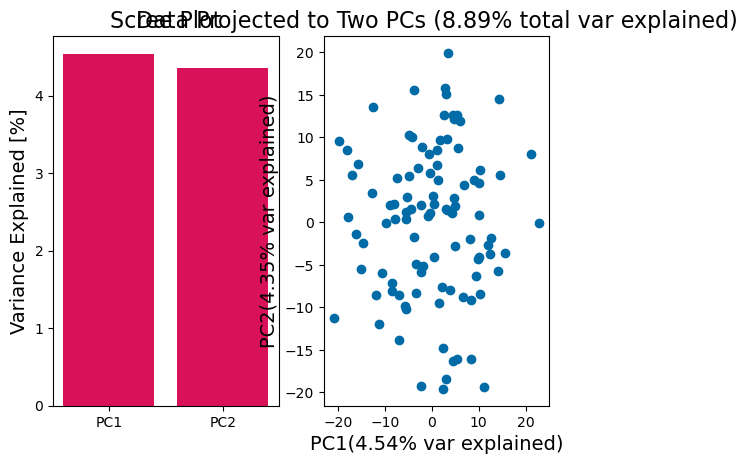

In [73]:
#plotting
fig,axs=plt.subplots(1,2)
labels=['PC1','PC2']
#scree plot
axs[0].bar(labels,explained_variance,color=colors[3])
axs[0].set_title('Scree Plot',size=16)
axs[0].set_ylabel('Variance Explained [%]',size=14)
#scatterplot of projected data
explained_variance=[x.round(2) for x in explained_variance]
axs[1].scatter(projected[:,0],projected[:,1],c=colors[0])
axs[1].set_title('Data Projected to Two PCs ('+str(sum(explained_variance))+'% total var explained)',size=16)
axs[1].set_xlabel('PC1('+str(explained_variance[0])+'% var explained)',size=14)
axs[1].set_ylabel('PC2('+str(explained_variance[1])+'% var explained)',size=14)

### Section c

In [74]:
SSElst=[] #list to contain SSE values
Ks=range(5,16) #Ks for testing optimal amount
for k in Ks:
    kmeans = KMeans(n_clusters=k) # Create an instance of the KMeans class
    kmeans.fit(projected) # Fit the model to the dataset   
    clusters = kmeans.predict(projected) # Predict the cluster for each data point
    SSElst.append(kmeans.inertia_) #Access the SSE of the clustering

C:\Users\denis\anaconda3\envs\Geeshot\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\denis\anaconda3\envs\Geeshot\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\denis\anaconda3\envs\Geeshot\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\denis\anaconda3\envs\Geeshot\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarn

Text(0, 0.5, 'SSE [A.U]')

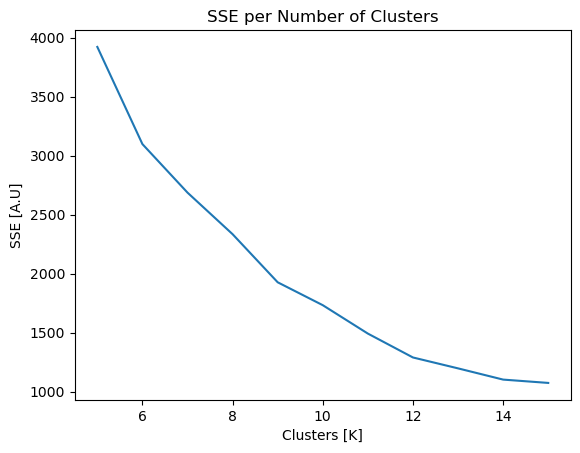

In [75]:
#plotting 
plt.figure()
plt.plot(list(Ks),SSElst)
plt.title('SSE per Number of Clusters')
plt.xlabel('Clusters [K]')
plt.ylabel('SSE [A.U]')

In [76]:
optimal_k=np.argmax(np.abs(np.diff(np.diff(np.array(SSElst)))))+6 #finding optimal K by finding the largest second derivative value(highest rate of change of the slopes)
#performing Kmeans with optimal K
kmeans=KMeans(n_clusters=optimal_k)
kmeans.fit(projected) #fitting to data
klabels = kmeans.labels_ #extracting labels for each point
centroids=kmeans.cluster_centers_ #extracting centroid coordinates

C:\Users\denis\anaconda3\envs\Geeshot\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


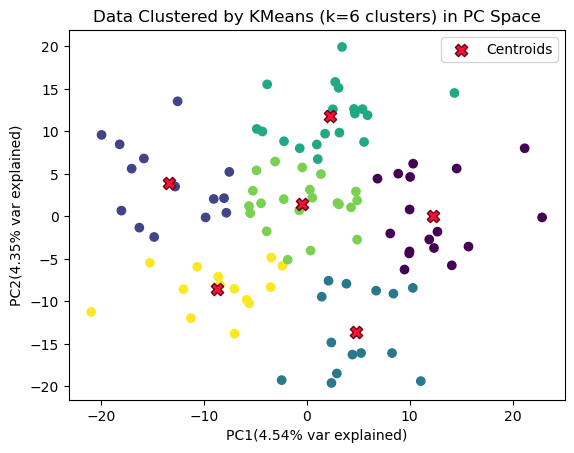

In [77]:
#plotting sorted data in PC space
plt.figure()
plt.scatter(projected[:,0],projected[:,1],c=klabels,cmap='viridis')
plt.scatter(centroids[:,0],centroids[:,1],label='Centroids',c='#FA0F36',edgecolor='#640212',s=77.7,marker='X')
plt.title('Data Clustered by KMeans (k='+str(optimal_k)+' clusters) in PC Space')
plt.xlabel('PC1('+str(explained_variance[0])+'% var explained)')
plt.ylabel('PC2('+str(explained_variance[1])+'% var explained)')
plt.legend()


### Section d

In [78]:
PC1weights=pca.components_[0] #finding PC1 weights from the feature vector
electrodes=np.argsort(PC1weights)[-5:] #finding top five dimensions by weight
print('The 5 electrodes with the heighest PC1 loading scores (from lowest to heighest) are:', electrodes+1)

The 5 electrodes with the heighest PC1 loading scores (from lowest to heighest) are: [54  8 64 30 48]


In [79]:
electroDF=pd.DataFrame({'E'+str(i+1):recordings[1:,i] for i in electrodes}) #creating dataframe of top 5 electrodes for train data (without first subject)
Arthur=pd.DataFrame({'E'+str(i+1):recordings[:1,i] for i in electrodes[:-1]}) #creating Arthur's data

In [80]:
names=list(electroDF.columns) #electrode names
model_cnfg = f"{names[4]}~{names[0]}+{names[1]}+{names[2]}+{names[3]}" #model configuration
#Poisson model
Poisson_model = sm.GLM.from_formula(model_cnfg, data=electroDF, family=sm.families.Poisson())
Poisson_results=Poisson_model.fit()
print(Poisson_results.summary())
print('The Theta vector for the Poisson regression is:\n', Poisson_results.params)
#linear model
Linear_model = sm.GLM.from_formula(model_cnfg, data=electroDF, family=sm.families.Gaussian())
Linear_results=Linear_model.fit()
print(Linear_results.summary())
print('The Theta vector the linear regression is:\n', Linear_results.params)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    E48   No. Observations:                   99
Model:                            GLM   Df Residuals:                       94
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -324.72
Date:                Fri, 17 Feb 2023   Deviance:                       202.84
Time:                        19:43:53   Pearson chi2:                     194.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1981
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2700      0.113     20.035      0.0

### Section e

In [81]:
#function for calculating BIC
def BIC(k,n,loglikelihood):
    return k*np.log(n)-2*loglikelihood
#function for calculating AIC
def AIC(k,loglikelihood):
    return 2*k-2*loglikelihood

Poisson_likelihood=Poisson_results.llf #likelihood of optimized parameters
P_AIC=AIC(4,Poisson_likelihood) 
P_BIC=BIC(4,99,Poisson_likelihood)

Linear_likelihood=Linear_results.llf  #likelihood of optimized parameters
L_AIC=AIC(4,Linear_likelihood)
L_BIC=BIC(4,99,Linear_likelihood)

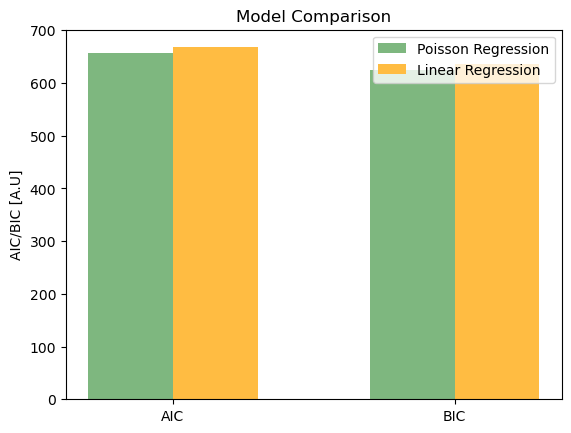

In [82]:
criteria=np.array([[P_AIC,P_BIC],[L_AIC,L_BIC]]) #array of model scores for plotting
width=0.3
r1 = np.arange(2)
r2 = [x + width for x in r1]
#bar plot for comparison
plt.figure()
plt.bar(r1,criteria[:,0],width=width,color=colors[1],label='Poisson Regression')
plt.bar(r2,criteria[:,1],width=width,color=colors[2],label='Linear Regression')
plt.xticks([r + width/2 for r in range(2)], ['AIC','BIC'])
plt.ylabel('AIC/BIC [A.U]')
plt.title('Model Comparison')
plt.legend()

In [83]:
Linear_predict=Linear_results.predict(Arthur) #predicting the 'boomer' electrode
print("The simulated value for Arthur's",names[-1],"electrode is:",round(recordings[0,electrodes[-1]],3), "Hz,\n while the predicted value is:", round(Linear_predict[0],3),"Hz")

The simulated value for Arthur's E48 electrode is: 10.9 Hz,
 while the predicted value is: 15.964 Hz
